### S15. Aprenentatge No Supervisat - Agrupació

In [1]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import QuantileTransformer, PolynomialFeatures, RobustScaler

##### Load the database

In [15]:
#Loading the dataset
df=pd.read_csv('delayedflights.csv', index_col=False, warn_bad_lines=True, error_bad_lines=False)
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [3]:
#select the relevant attributes for an objective prediction before flying.  
df=df[['Month', 'DayOfWeek', 'DepTime','ArrTime', 'UniqueCarrier', 'CRSElapsedTime', 
       'Origin', 'Dest','DepDelay','CarrierDelay','Distance'
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay','ArrDelay']]
df = df.sample(frac =.05).reset_index().drop(['index'], axis=1)
df.head(3)

,Month,DayOfWeek,DepTime,ArrTime,UniqueCarrier,CRSElapsedTime,Origin,Dest,Distance,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay
0,5,2,1838.0,1944.0,WN,70.0,DAL,AMA,324,8.0,NaN,NaN,NaN,NaN,NaN,4.0
1,4,4,956.0,1138.0,DL,105.0,ATL,PIT,526,6.0,NaN,NaN,NaN,NaN,NaN,3.0
2,11,2,1458.0,1623.0,EV,87.0,ROA,ATL,357,65.0,7.0,0.0,0.0,0.0,56.0,63.0


In [4]:
# Delete both ArrTime and ArrDelay (target column) null values because they are most likely linked to cancellations and diverions
df.dropna(subset=['ArrTime','UniqueCarrier','ArrDelay'], inplace=True)

In [5]:
df.isnull().sum()

Month                    0
DayOfWeek                0
DepTime                  0
ArrTime                  0
UniqueCarrier            0
CRSElapsedTime           0
Origin                   0
Dest                     0
Distance                 0
DepDelay                 0
CarrierDelay         34176
WeatherDelay         34176
NASDelay             34176
SecurityDelay        34176
LateAircraftDelay    34176
ArrDelay                 0
dtype: int64

In [6]:
# Convert selected columns nulls to 0
cols= ['CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
df[cols]=df[cols].fillna(0)

In [7]:
#Simplifying the Arrival and Departure time into time frames (in this case, numericals representing morning, afternon, evenening and night)
df['DepTime'] = pd.cut(df.DepTime, bins=4,labels=[1,0.25,0.5,0.75])
df['ArrTime'] = pd.cut(df.ArrTime, bins=4,labels=[1,0.25,0.5,0.75])

In [8]:
#bin Delay related columns by 10 mins and also preprocess with QuantileTransformer
            def truncate(n):
                if n < 10:
                    min=0
                elif n<100:
                    low=str(n)
                    min=int(low[0])*10
                elif n<1000:
                    low=str(n)
                    min=int(low[0:2])*10
                else:
                    low=str(n)
                    min=int(low[0:3])*10
                return min

scaler = QuantileTransformer()
cols= ['DepDelay','ArrDelay','CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
for co in cols:
    df[co] = df[co].apply(truncate)
    df[[co]] = scaler.fit_transform(df[[co]])

In [9]:
df.head(10)

,Month,DayOfWeek,DepTime,ArrTime,UniqueCarrier,CRSElapsedTime,Origin,Dest,Distance,DepDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,ArrDelay
0,5,2,0.75,0.75,WN,70.0,DAL,AMA,324,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,4,4,0.25,0.25,DL,105.0,ATL,PIT,526,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,11,2,0.50,0.50,EV,87.0,ROA,ATL,357,0.801301,0.000000,0.0,0.000000,0.0,0.902402,0.789289
3,1,5,0.75,0.75,CO,147.0,TPA,IAH,787,0.616617,0.000000,0.0,0.937938,0.0,0.841842,0.853353
4,6,1,0.50,0.50,DL,175.0,BOS,ATL,946,0.697698,0.000000,0.0,0.000000,0.0,0.790290,0.497497
5,6,1,0.75,1.00,US,115.0,PHX,SFO,651,0.495996,0.856356,0.0,0.000000,0.0,0.000000,0.606607
6,6,4,0.50,1.00,US,300.0,PHX,JFK,2153,0.862863,0.949449,0.0,0.000000,0.0,0.000000,0.789289
7,7,2,0.50,0.50,DL,124.0,SEA,SLC,689,0.495996,0.000000,0.0,0.000000,0.0,0.721221,0.348849
8,10,1,0.50,0.75,XE,73.0,SDF,CLE,304,0.295295,0.000000,0.0,0.000000,0.0,0.000000,0.000000
9,5,1,0.75,0.75,AA,70.0,IND,ORD,177,0.616617,0.000000,0.0,0.000000,0.0,0.721221,0.348849


In [10]:
#delete the exceptional single outlier
df=df.drop(df['DepDelay'].idxmax())

In [11]:
##### Frequency Encoding columna Month, DayOfWeek i UniqueCarrier
freq=['Month','DayOfWeek','UniqueCarrier','Origin','Dest']
for xx in freq:
    fe=df.groupby(xx).size()/len(df)
    df.loc[:,xx]=df[xx].map(fe)

In [12]:
#Apply RobustScaler to CRSElapsedTime and Distance

scaler1 = RobustScaler()
df[['CRSElapsedTime','Distance']] = scaler1.fit_transform(df[['CRSElapsedTime','Distance']])

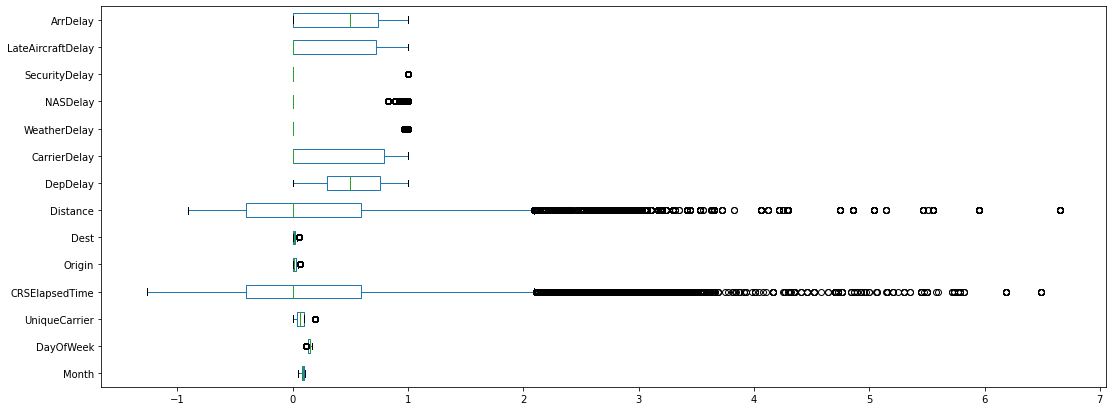

In [13]:
df.plot(kind='box',figsize=(18,7),vert=False)

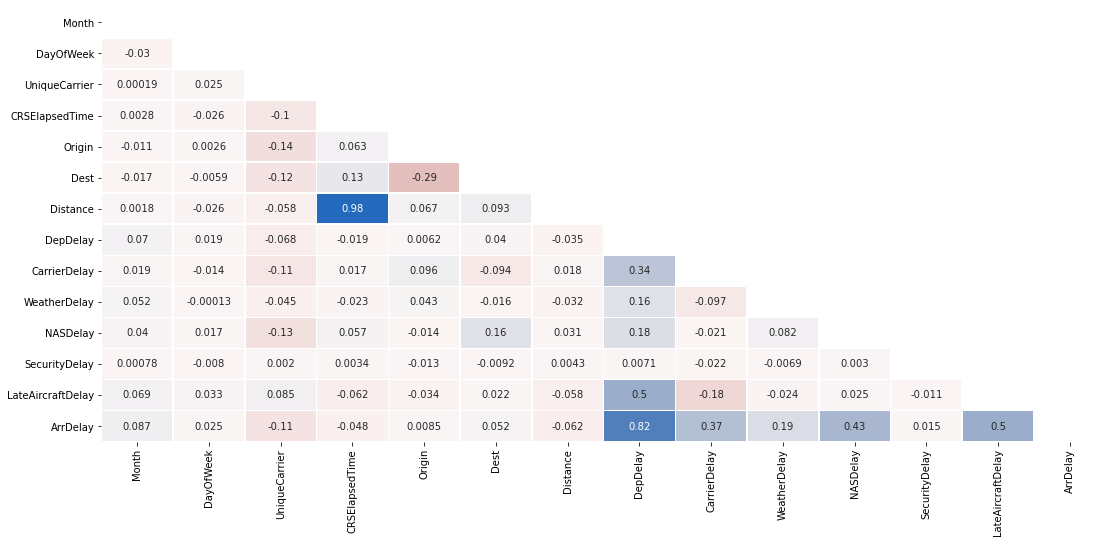

In [14]:
# Correlation Heatmap 
corr = df.corr()
cmap = sns.light_palette("#0c2a70", as_cmap=True)
mask = np.triu(corr)
plt.figure(figsize=(18,8))
sns.heatmap(corr, cmap='vlag_r', annot=True, linewidths=0.5, center=0, cbar=False, xticklabels=True,
           mask=mask)

In [15]:
df=df.drop(['Distance'],axis=1)

In [16]:
df.to_csv('delays_prep.csv')